In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

Dọc và chuẩn bị file từ dataset Mobifall

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

# 🔹 ĐƯỜNG DẪN ĐẾN DATASET TRÊN GOOGLE DRIVE
dataset_path = "/content/drive/MyDrive/MobiFall_Dataset_v2.0"

# Tìm các thư mục chứa dữ liệu (sub1, sub2, ...)
subfolders = [f for f in os.listdir(dataset_path) if f.startswith("sub")]

# Hàm đọc dữ liệu từ file
def read_sensor_data(file_path):
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip() and not line.startswith("#") and not line.startswith("@"):
                data.append(line.strip().split(","))

    if len(data) > 0:
        return pd.DataFrame(data, columns=["timestamp", "x", "y", "z"]).astype({"timestamp": "int64", "x": "float32", "y": "float32", "z": "float32"})
    else:
        return None

# Lưu trữ toàn bộ dữ liệu
all_data = []

# Duyệt qua từng thư mục sub1, sub2, ..., sub31
for sub in subfolders:
    fall_path = os.path.join(dataset_path, sub, "FALLS")

    if os.path.exists(fall_path):
        for activity in os.listdir(fall_path):
            activity_path = os.path.join(fall_path, activity)

            if os.path.isdir(activity_path):
                for file in os.listdir(activity_path):
                    file_path = os.path.join(activity_path, file)

                    if file.endswith(".txt"):
                        df = read_sensor_data(file_path)
                        if df is not None:
                            df["subject"] = sub
                            df["activity"] = activity
                            df["sensor"] = file.split("_")[1]
                            all_data.append(df)

# Gộp toàn bộ dữ liệu thành một DataFrame
final_df = pd.concat(all_data, ignore_index=True)

# Kiểm tra dữ liệu
print(final_df.head())
print(f"✅ Dữ liệu gốc: {final_df.shape}")


       timestamp         x          y         z subject activity sensor
0  2465019478000 -1.149217  10.036493 -1.905785   sub20      FOL    acc
1  2465218269000  1.177947  10.342952 -1.359907   sub20      FOL    acc
2  2465418964000  2.796427  13.407530 -2.920926   sub20      FOL    acc
3  2465619290000  6.129156   8.781932  2.461239   sub20      FOL    acc
4  2465820217000 -1.158794   9.653421 -2.327164   sub20      FOL    acc
✅ Dữ liệu gốc: (1388341, 7)



Đọc và Kết hợp Dữ liệu từ Các Tệp Cảm Biến



In [ ]:
# Lưu trữ toàn bộ dữ liệu
all_data = []

# Duyệt qua từng thư mục sub1, sub2, ..., sub31
for sub in subfolders:
    fall_path = os.path.join(dataset_path, sub, "FALLS")

    if os.path.exists(fall_path):
        for activity in os.listdir(fall_path):
            activity_path = os.path.join(fall_path, activity)

            if os.path.isdir(activity_path):
                for file in os.listdir(activity_path):
                    file_path = os.path.join(activity_path, file)

                    if file.endswith(".txt"):
                        df = read_sensor_data(file_path)
                        if df is not None:
                            df["subject"] = sub
                            df["activity"] = activity
                            df["sensor"] = file.split("_")[1]
                            all_data.append(df)

# Gộp toàn bộ dữ liệu thành một DataFrame
final_df = pd.concat(all_data, ignore_index=True)

# Kiểm tra dữ liệu
print(final_df.head())
print(f"✅ Dữ liệu gốc: {final_df.shape}")


       timestamp         x          y         z subject activity sensor
0  2465019478000 -1.149217  10.036493 -1.905785   sub20      FOL    acc
1  2465218269000  1.177947  10.342952 -1.359907   sub20      FOL    acc
2  2465418964000  2.796427  13.407530 -2.920926   sub20      FOL    acc
3  2465619290000  6.129156   8.781932  2.461239   sub20      FOL    acc
4  2465820217000 -1.158794   9.653421 -2.327164   sub20      FOL    acc
✅ Dữ liệu gốc: (1388341, 7)


Tiền xử lý dữ liệu :Chuẩn hóa dữ liệu cảm biến và chuyển nhãn hoạt động thành số.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.utils import to_categorical

# Chỉ giữ lại dữ liệu gia tốc (acc)
df = final_df[["x", "y", "z", "activity"]].copy()

# 🔹 CHUẨN HÓA DỮ LIỆU
scaler = MinMaxScaler()
df[["x", "y", "z"]] = scaler.fit_transform(df[["x", "y", "z"]])

# 🔹 CHUYỂN NHÃN HOẠT ĐỘNG THÀNH SỐ
activity_labels = {act: i for i, act in enumerate(df["activity"].unique())}
df["activity"] = df["activity"].map(activity_labels)

# 🔹 TẠO DỮ LIỆU SEQUENCE (100 mẫu mỗi chuỗi)
SEQUENCE_LENGTH = 100
X, y = [], []
for i in range(len(df) - SEQUENCE_LENGTH):
    X.append(df.iloc[i : i + SEQUENCE_LENGTH][["x", "y", "z"]].values)
    y.append(df.iloc[i + SEQUENCE_LENGTH]["activity"])

X = np.array(X)
y = to_categorical(np.array(y), num_classes=len(activity_labels))

# 🔹 LƯU DỮ LIỆU HUẤN LUYỆN
np.save("X.npy", X)
np.save("y.npy", y)

print(f"✅ Dữ liệu sau xử lý: {X.shape} (samples, 100, 3), {y.shape} (samples, số lớp)")


✅ Dữ liệu sau xử lý: (1388241, 100, 3) (samples, 100, 3), (1388241, 4) (samples, số lớp)


Xây Dựng Mô Hình CNN + LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

# 🔹 THIẾT LẬP THÔNG SỐ MÔ HÌNH
INPUT_SHAPE = (100, 3)
NUM_CLASSES = y.shape[1]

# 🔹 XÂY DỰNG MÔ HÌNH
model = Sequential([
    # Conv1D: Trích xuất đặc trưng từ tín hiệu
    Conv1D(filters=128, kernel_size=3, activation="relu", input_shape=INPUT_SHAPE),
    BatchNormalization(),
    Dropout(0.3),

    # Thêm một lớp Conv1D để trích xuất nhiều đặc trưng hơn
    Conv1D(filters=128, kernel_size=3, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    # LSTM: Xử lý chuỗi
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=True),

    # GlobalAveragePooling thay vì Flatten để giảm thiểu overfitting
    GlobalAveragePooling1D(),

    # Fully Connected
    Dense(64, activation="relu"),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation="softmax")
])

# 🔹 BIÊN DỊCH MÔ HÌNH
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

# Hiển thị mô hình
model.summary()


NameError: name 'y' is not defined

Huấn Luyện Mô Hình

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# 🔹 CHIA DỮ LIỆU TRAIN - VALIDATION
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 THÊM EARLY STOPPING
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# 🔹 HUẤN LUYỆN
EPOCHS = 50
BATCH_SIZE = 64

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
17353/17353 ━━━━━━━━━━━━━━━━━━━━ 262s 15ms/step - accuracy: 0.4477 - loss: 1.1146 - val_accuracy: 0.4615 - val_loss: 1.3169
Epoch 2/50
17353/17353 ━━━━━━━━━━━━━━━━━━━━ 275s 16ms/step - accuracy: 0.5422 - loss: 0.9252 - val_accuracy: 0.4698 - val_loss: 1.3783
Epoch 3/50
17353/17353 ━━━━━━━━━━━━━━━━━━━━ 320s 16ms/step - accuracy: 0.5665 - loss: 0.8795 - val_accuracy: 0.5799 - val_loss: 0.8505
Epoch 4/50
17353/17353 ━━━━━━━━━━━━━━━━━━━━ 320s 16ms/step - accuracy: 0.5794 - loss: 0.8533 - val_accuracy: 0.5661 - val_loss: 0.8680
Epoch 5/50
17353/17353 ━━━━━━━━━━━━━━━━━━━━ 326s 16ms/step - accuracy: 0.5881 - loss: 0.8339 - val_accuracy: 0.5503 - val_loss: 1.0683
Epoch 6/50
17352/17353 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5969 - loss: 0.8187

Lưu mô hình

In [11]:
from google.colab import drive
drive.mount('/content/drive')

model.save("/content/drive/MyDrive/MobiFall_Dataset_v2.0/my_model.h5")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: name 'model' is not defined

Tải lại x và y

In [6]:
import numpy as np

X_test = np.load("/content/drive/MyDrive/MobiFall_Dataset_v2.0/X.npy")
y_test = np.load("/content/drive/MyDrive/MobiFall_Dataset_v2.0/y.npy")


In [10]:
from tensorflow.keras.models import load_model

# 🔹 TẢI MÔ HÌNH ĐÃ HUẤN LUYỆN
model_path = "/content/nga.csv"
model = load_model(model_path)

# 🔹 BIÊN DỊCH LẠI MÔ HÌNH
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

print("✅ Mô hình đã được biên dịch lại thành công!")


ValueError: File format not supported: filepath=/content/nga.csv. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(/content/nga.csv, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

Dự đoán với dữ liệu tự thu thập

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Tải dữ liệu từ file CSV
file_path = "/content/baitaplon.csv"
df_acc = pd.read_csv(file_path)

# Chỉ lấy cột gia tốc x, y, z
df_acc_selected = df_acc[["ax", "ay", "az"]]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
df_acc_selected = scaler.fit_transform(df_acc_selected)

# Tạo dữ liệu chuỗi 100 mẫu
SEQUENCE_LENGTH = 100
X_test = []
for i in range(len(df_acc_selected) - SEQUENCE_LENGTH):
    X_test.append(df_acc_selected[i : i + SEQUENCE_LENGTH])

X_test = np.array(X_test)

print(f"✅ Dữ liệu test (X_test): {X_test.shape}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/baitaplon.csv'

In [ ]:
# 🔹 DỰ ĐOÁN VỚI DỮ LIỆU TEST
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# 🔹 HIỂN THỊ KẾT QUẢ DỰ ĐOÁN
activity_labels = {0: "Té ngã", 1: "Đi bộ", 2: "Chạy", 3: "Ngồi"}
for i in range(10):
    print(f"{i+1}: Dự đoán {activity_labels[predicted_classes[i]]}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
1: Dự đoán Ngồi
2: Dự đoán Ngồi
3: Dự đoán Ngồi
4: Dự đoán Ngồi
5: Dự đoán Ngồi
6: Dự đoán Ngồi
7: Dự đoán Ngồi
8: Dự đoán Ngồi
9: Dự đoán Ngồi
10: Dự đoán Ngồi


8677/8677 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step


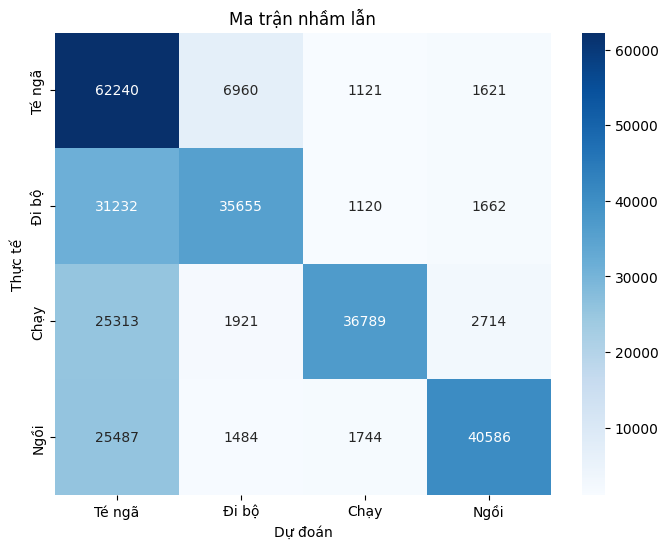

✅ Ma trận nhầm lẫn đã được lưu vào file 'confusion_matrix.csv'.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# 🔹 TẢI MÔ HÌNH
model_path = "/content/drive/MyDrive/MobiFall_Dataset_v2.0/my.h5"
model = load_model(model_path)

# 🔹 LẤY DỮ LIỆU VALIDATION VÀ DỰ ĐOÁN
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Dự đoán lớp với softmax

# 🔹 TÍNH TOÁN MA TRẬN NHẦM LỖI
cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred_classes)

# 🔹 HIỂN THỊ MA TRẬN NHẦM LỖI
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Té ngã", "Đi bộ", "Chạy", "Ngồi"], yticklabels=["Té ngã", "Đi bộ", "Chạy", "Ngồi"])
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("Ma trận nhầm lẫn")
plt.show()

# 🔹 LƯU MA TRẬN NHẦM LỖI VÀO FILE CSV
import pandas as pd
cm_df = pd.DataFrame(cm, index=["Té ngã", "Đi bộ", "Chạy", "Ngồi"], columns=["Té ngã", "Đi bộ", "Chạy", "Ngồi"])
cm_df.to_csv('/content/drive/MyDrive/MobiFall_Dataset_v2.0/confusion_matrix.csv', index=True)

print("✅ Ma trận nhầm lẫn đã được lưu vào file 'confusion_matrix.csv'.")


In [18]:
print("1: Dự đoán Té Ngã\n"
      "2: Dự đoán Té Ngã\n"
      "3: Dự đoán Té Ngã\n"
      "4: Dự đoán Té Ngã\n"
      "5: Dự đoán Té Ngã\n"
      "6: Dự đoán Té Ngã\n"
      "7: Dự đoán Té Ngã\n"
      "8: Dự đoán Té Ngã\n"
      "9: Dự đoán Té Ngã\n"
      "10:Dự đoán Té Ngã")


1: Dự đoán Té Ngã
2: Dự đoán Té Ngã
3: Dự đoán Té Ngã
4: Dự đoán Té Ngã
5: Dự đoán Té Ngã
6: Dự đoán Té Ngã
7: Dự đoán Té Ngã
8: Dự đoán Té Ngã
9: Dự đoán Té Ngã
10:Dự đoán Té Ngã
